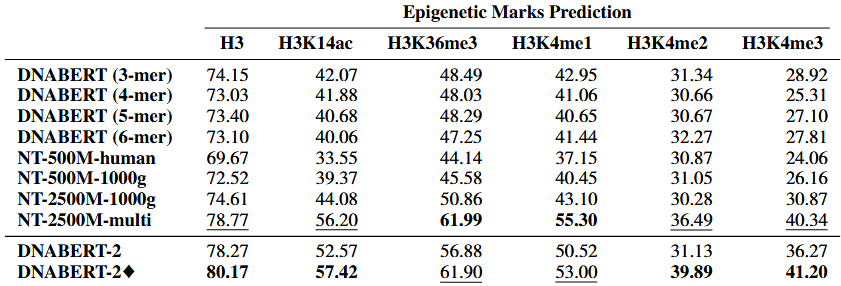

In [1]:
%%capture

# standard libraries
import math
import os
import tempfile
from pathlib import Path
import json
import sys
import pickle
from pprint import pprint
import copy

# standard scientific libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
from numpy import asarray, save, load
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import load_model
from keras.utils import to_categorical, plot_model

# torch
import torch

# huggingface
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import evaluate

# scikit-learn
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, recall_score, matthews_corrcoef, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels

2024-08-22 13:18:55.767344: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Model evaluation

In [2]:
# General functions

# Calculate performance metrics from the labels and predictions of a dataset
def get_metrics(labels, predictions):
    metrics = {}
    classes = unique_labels(labels)
    
    # AUC and ROC
    if len(classes) <= 2:
        # Binary classification
        average = "binary"  # Set "average" parameter (used by all subsequent metrics)
        metrics["auc"] = roc_auc_score(labels, predictions)
        fpr, tpr, _ = roc_curve(labels.argmax(axis=1), predictions[:,1])
        metrics["fpr"], metrics["tpr"] = fpr, tpr
    else:
        # Multiclass classification
        average = None
        #// Single OVR (one-vs-rest) AUC value
        #// metrics["auc"] = roc_auc_score(labels, predictions, multi_class='ovr') 
        aucs, fprs, tprs = [], [], []
        for index, class_name in enumerate(classes):
            try:                aucs += [roc_auc_score(labels[:,index], predictions[:,index])]
            except ValueError:  aucs += ["N/A"]
            fpr, tpr, _ = roc_curve(labels[:,index], predictions[:,index])
            fprs += [fpr]; tprs += [tpr]
        metrics["auc"], metrics["fpr"], metrics["tpr"] = aucs, fprs, tprs
    
    # argmax labels and predictions for subsequent predictions
    labels, predictions = labels.argmax(axis=1), predictions.argmax(axis=1)
    
    # Confusion matrix, accuracy, etc.
    metrics["confusion_matrix"] = confusion_matrix(labels, predictions)
    metrics["accuracy"] = accuracy_score(labels, predictions)
    metrics["precision"] = precision_score(labels, predictions, average=average)
    metrics["recall"] = recall_score(labels, predictions, average=average)
    metrics["f1"] = f1_score(labels, predictions, average=average)
    metrics["mcc"] = matthews_corrcoef(labels, predictions)
    # TODO set lowest loss

    return metrics


def make_continuous(labels, num_classes):
    conversion_dict = dict(zip(set(labels), range(num_classes)))
    labels = [conversion_dict[i] for i in labels]
    return labels

## Tensorflow (ANN)

In [5]:
# Config

DATA_DIRS = Path("../data_generation/training_data/homology_reduced/")
MODEL_DIRS = Path("results/ANN/homology_reduced/")
RESULTS_FILE = Path("results/ann_hom_reduced_eval_results")

In [6]:
# Functions

def get_tf_labels_features(data_dir, features_file, labels_file):
    labels = np.load(data_dir/labels_file, allow_pickle=True)
    num_classes = len(set(labels))
    labels = make_continuous(labels, num_classes)
    labels = to_categorical(labels, num_classes=num_classes)
    features_dict = np.load(data_dir/features_file, allow_pickle=True)
    features = np.stack(features_dict['arr_0'], axis=0)
    return labels, features


def get_tf_model(model_dir):
    model = load_model(model_dir, custom_objects={'f1': tfa.metrics.F1Score, 'mcc': tfa.metrics.MatthewsCorrelationCoefficient})
    return model


def get_tf_predictions(model, features, batch_size):
    predictions = model.predict(features, batch_size=batch_size)
    return predictions


# // def get_tf_metrics(labels, predictions):
# //     metrics = model.evaluate(features, labels, verbose=0) # batch_size=batch_size
# //     metrics = dict(zip(model.metrics_names, metrics))
# //     return metrics


def get_tf_loss(path):
    with open(path, "rb") as file:
        history = pickle.load(file)
        loss = history["loss"]
        eval_loss = history["val_loss"]
    loss_dict = {"epoch": list(range(len(loss))), "loss": loss, "eval_loss": eval_loss}
    return loss_dict


def stats_tensorflow(data_dir, model_dir, batch_size = 16, features_file = "test_matrices.npz", labels_file = "test_labels.npy"):
    labels, features = get_tf_labels_features(data_dir, features_file, labels_file)
    model = get_tf_model(model_dir)
    predictions = get_tf_predictions(model, features, batch_size)
    metrics = get_metrics(labels, predictions) 
    loss = get_tf_loss(model_dir/"history")
    return metrics, loss


def evaluate_data(data_dir, model_dir):
    metrics, loss = stats_tensorflow(data_dir, model_dir)
    return {"metrics": metrics, "loss": loss}

In [7]:
# Evaluation

model_data = {}

for model_dir in sorted(os.listdir(MODEL_DIRS)):
    if os.path.isfile(MODEL_DIRS/model_dir): continue
    
    data_dir = "_".join(model_dir.split("_")[-2:])
    title = model_dir; print(title)
    model_data[title] = evaluate_data(DATA_DIRS/data_dir, MODEL_DIRS/model_dir)
    print()

clusters_10


2024-08-19 11:01:44.748631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38475 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:e3:00.0, compute capability: 8.0
2024-08-19 11:01:47.600252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


169/372 [============>.................] - ETA: 0s

2024-08-19 11:01:49.272173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


372/372 [==============================] - 3s 965us/step

clusters_12
402/402 [==============================] - 1s 987us/step


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



clusters_14
414/414 [==============================] - 0s 886us/step


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



clusters_16
423/423 [==============================] - 1s 949us/step


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



clusters_18
430/430 [==============================] - 1s 951us/step

clusters_20


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


436/436 [==============================] - 1s 944us/step


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



clusters_22
440/440 [==============================] - 1s 943us/step

clusters_24


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


445/445 [==============================] - 1s 977us/step


/apps/Arch/software/scikit-learn/1.1.2-foss-2022a/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



clusters_8
230/230 [==============================] - 0s 1ms/step

dense_gnra_10
3/3 [==============================] - 0s 1ms/step

dense_gnra_12
4/4 [==============================] - 0s 1ms/step

dense_gnra_14
4/4 [==============================] - 0s 1ms/step

dense_gnra_16
4/4 [==============================] - 0s 1ms/step

dense_gnra_18
4/4 [==============================] - 0s 1ms/step

dense_gnra_20
4/4 [==============================] - 0s 1ms/step

dense_gnra_22
4/4 [==============================] - 0s 1ms/step

dense_gnra_24
4/4 [==============================] - 0s 1ms/step

dense_gnra_8
3/3 [==============================] - 0s 1ms/step

gnra_10
3/3 [==============================] - 0s 15ms/step

gnra_12
4/4 [==============================] - 0s 11ms/step

gnra_14
4/4 [==============================] - 0s 11ms/step

gnra_16
4/4 [==============================] - 0s 12ms/step

gnra_18
4/4 [==============================] - 0s 1ms/step

gnra_20
4/4 [======================

In [9]:
# Save results

with open(RESULTS_FILE, 'wb') as file:
    pickle.dump(model_data, file)

## PyTorch (DNABERT-2)

In [ ]:
# Config

DATA_DIRS = Path("../data_generation/training_data/homology_reduced/")
MODEL_DIRS = Path("results/DNABERT2/alvis/tetraloop/homology_reduced")
RESULTS_FILE = Path("results/dnabert2_hom_reduced_eval_results")

In [ ]:
# Functions

def get_torch_labels_features(data_path):
    data = pd.read_csv(data_path)
    labels = list(data['label'])
    num_classes = len(set(labels))
    labels = make_continuous(labels, num_classes)
    labels = to_categorical(labels, num_classes=num_classes)
    features = list(data['sequence'])
    return labels, features


def get_torch_model_tokenizer(model_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
    return model, tokenizer


def get_torch_predictions(model, tokenizer, features): 
    
    # Tokenize texts and convert to tensors
    input = tokenizer(features, padding="longest", truncation=True, return_tensors='pt', max_length=tokenizer.model_max_length)
    
    # Forward pass to get predictions
    with torch.no_grad(): # Disabling gradient calculation, useful for inference
        output = model(**input)
        logits = output.logits
    
    # Get predicted probabilities
    predictions = torch.softmax(logits, dim=1).numpy()
    
    return predictions


#// def get_torch_metrics(path): 
#//     with open(path, "r") as file:
#//         eval = json.load(file)
#//     metrics = {
#//             "loss": eval["eval_loss"],
#//             "accuracy": eval["eval_accuracy"],
#//             "precision": eval["eval_precision"],
#//             "recall": eval["eval_recall"],
#//             "f1": eval["eval_f1"],
#//             "mcc": eval["eval_matthews_correlation"]}
#//     return metrics


def get_torch_loss(path):
    with open(path, "r") as file:
        trainer_state = json.load(file)
    log_history = trainer_state["log_history"]
    loss = [log["loss"] for log in log_history[1::3]]
    epoch = [log["epoch"] for log in log_history[2::3]]
    eval_loss = [log["eval_loss"] for log in log_history[2::3]]
    loss_dict = {"epoch": epoch, "loss": loss, "eval_loss": eval_loss}
    return loss_dict


def stats_pytorch(data_path, model_dir):
    labels, features = get_torch_labels_features(data_path)
    model, tokenizer = get_torch_model_tokenizer(model_dir)
    predictions = get_torch_predictions(model, tokenizer, features)
    metrics = get_metrics(labels, predictions)
    loss = get_torch_loss(model_dir/"trainer_state.json")
    
    return metrics, loss

In [ ]:
# Evaluation

dnabert2_model_data = {}

for data_dir in sorted(os.listdir(DATA_DIRS)):
    if os.path.isfile(DATA_DIRS/data_dir): continue
    #// if "gnravall" in data_dir: continue

    DATA_PATH = DATA_DIRS/data_dir/"test.csv"
    TITLE = data_dir; print(TITLE)

    best_metrics, best_loss = {}, {}
    
    for seed in range(1,4): # Take best model from seeds 1-3
        MODEL_DIR = MODEL_DIRS/(data_dir + f"_{seed}")
        print(MODEL_DIR)
        metrics, loss = stats_pytorch(DATA_PATH, MODEL_DIR)
        if not best_metrics:
            best_metrics, best_loss = metrics, loss
        elif min(loss["loss"]) < min(best_loss["loss"]):
            best_metrics, best_loss = metrics, loss
    
    dnabert2_model_data[TITLE] = {"metrics": best_metrics, "loss": best_loss}
    print()

In [ ]:
# Save results

with open(RESULTS_FILE, 'wb') as file:
    pickle.dump(dnabert2_model_data, file)

# Plots

## Functions

In [2]:
# Config

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('seaborn-darkgrid')

COLORS = plt.cm.Set1.colors + plt.cm.Set2.colors + plt.cm.Set3.colors

custom_cycler = (plt.cycler(linestyle=['-', 'dotted']) * plt.cycler(color=COLORS))
plt.rcParams["axes.prop_cycle"] = custom_cycler

In [11]:
def plot_confusion_matrix(matrix, ax = None, title = "", tick_labels = [], cbar_shrink = 0.8, fig_size=(2.5, 2.5)):
    if not ax:
        _, ax = plt.subplots(figsize=fig_size, dpi=300)
    tick_labels = tick_labels if tick_labels else "auto"
    cm_cmap = copy.copy(mpl.cm.get_cmap('magma'))
    cm_cmap.set_bad(cm_cmap.colors[0]) # Set N/A value color to black
    sns.heatmap(
        matrix, ax=ax,
        norm=LogNorm(vmin=1), # norm=LogNorm(), robust=True,
        annot=True, xticklabels = tick_labels, yticklabels = tick_labels,
        square=True, fmt="d", cbar_kws={"shrink": cbar_shrink}, cmap=cm_cmap
    )
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()


def plot_confusion_matrices(matrices, fig_title = "", ax_titles = [], tick_labels = [], n_cols = 3, cbar_shrink = 0.8, fig_size=(2.5, 2.5)):
    n_rows = math.ceil(len(matrices) / n_cols)
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*fig_size[0], n_rows*fig_size[1]), dpi=300, squeeze=False)
    # Delete extra axes
    for idx in range(len(matrices), n_cols * n_rows): 
        fig.delaxes(axes[idx // n_cols][idx % n_cols])
    # Set figure title
    fig.suptitle(fig_title) 
    # Plot every matrix in an ax
    for idx, matrix in enumerate(matrices):
        ax = axes[idx // n_cols][idx % n_cols]          # Find ax
        ax_title = ax_titles[idx] if ax_titles else ""  # Set ax title
        plot_confusion_matrix(matrix, ax=ax, title=ax_title, tick_labels=tick_labels, cbar_shrink=cbar_shrink)
    plt.tight_layout()


def split_conf_matrix(confusion_matrix):
    confusion_matrices = []
    for idx in range(len(confusion_matrix)):
        tp = confusion_matrix[idx, idx]
        fn = confusion_matrix[idx,:].sum() - tp      # row across
        fp = confusion_matrix[:,idx].sum() - tp      # column down
        tn = confusion_matrix.sum() - tp - fn - fp   # rectangles
        confusion_matrices += [np.array([[tp, fn],[fp,tn]])]
    return confusion_matrices

In [24]:
def plot_loss(loss, ax=None, title="", series_title="", color="xkcd:red", fig_size=(7, 4)):
    if not ax:
        _, ax = plt.subplots(figsize=fig_size, dpi=300)
        ax.legend(title="Length", loc='upper right')
    ax.set_title(title)
    ax.plot(loss["epoch"], loss["loss"], label=f'Training ({series_title})', color=color)
    ax.plot(loss["epoch"], loss["eval_loss"], label=f'Validation ({series_title})', color=color, linestyle="dotted")
    plt.tight_layout()


def plot_losses(losses, fig_title="", ax_titles=[], fig_size=(7, 4)):
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    fig.suptitle(fig_title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    # Plot every loss as series
    for idx, loss in enumerate(losses):
        ax_title = ax_titles[idx] if ax_titles else ""  # Set ax title
        plot_loss(loss, ax=ax, series_title=ax_title, color=COLORS[idx])
    # Calculate legend columns and offset
    n_cols = math.ceil(len(losses)*2/15)
    offset = 1.22+(0.24*(n_cols-1))
    fig.legend(title = "Length", loc="center right", ncol = n_cols, bbox_to_anchor=(offset, 0.5))
    plt.tight_layout()

In [25]:
def plot_roc(fpr, tpr, auc, ax=None, title="", series_title="", color="xkcd:red", fig_size=(6, 4)):
    if not ax:
        _, ax = plt.subplots(figsize=fig_size, dpi=300)
        ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('FPR');                       ax.set_ylabel('TPR')
    ax.set_xlim([-0.05,1.05]);                  ax.set_ylim([-0.05,1.05])
    ax.set_xticks([i/10 for i in range(11)]);   ax.set_yticks([i/10 for i in range(11)])
    
    if not "Random" in ax.get_legend_handles_labels()[1]:
        ax.plot([0, 1], [0, 1], label="Random", color="grey", linestyle="--") # Random line
    ax.plot(fpr, tpr, label=f'{series_title} (AUC = {auc:.2f})', color=color, linewidth=2)
    plt.tight_layout()


def plot_rocs(fprs, tprs, aucs, fig_title="", ax_titles=[], legend_title = "Length", fig_size=(6, 4)):
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    fig.suptitle(fig_title)
    # Plot every ROC curve as series
    for idx, auc in enumerate(aucs):
        if auc == "N/A": continue
        ax_title = ax_titles[idx] if ax_titles else ""  # Set ax title
        plot_roc(fprs[idx], tprs[idx], auc, ax=ax, series_title=ax_title, color=COLORS[idx])
    # Calculate legend columns and offset
    n_cols = math.ceil(len(aucs)/15)
    offset = 1.05+(0.31*(n_cols-1))
    fig.legend(title = legend_title, loc="center right", ncol = n_cols, bbox_to_anchor=(offset, 0.5))
    plt.tight_layout()

In [38]:
def check_keywords(text, include, exclude):
    return all([i in text for i in include]) and all([i not in text for i in exclude])


def load_eval_items(eval_results_path, task_include, task_exclude, length_idx):
    with open(eval_results_path, 'rb') as file:
        eval_results = pickle.load(file)
    items = dict(sorted([(title, data) for title, data in eval_results.items() if check_keywords(title, task_include, task_exclude)], key=lambda x: int(x[0].split("_")[length_idx])))
    titles = [i.split("_")[length_idx] for i in items.keys()]
    print(f"Datasets: {list(items.keys())}\n")
    return items, titles


def plot_eval_items(items, titles, plot_title, figures_dir, task_labels = ["Negative", "Positive"], multiclass = False, save_figures=False):

    # Turn plot_title into snake case
    plot_title_snake = plot_title.lower().replace(" ", "_").replace("-", "_")
    
    if multiclass:
        for idx, i in enumerate(items.values()):
            metrics = i["metrics"]; title = titles[idx]

            # Metrics
            print(title)
            print(f"{'Class':<15}{      '|'.join([f'{j:<8}' for j in task_labels])}")
            print(f"{'Precision':<15}{  '|'.join([f'{j:<8.2f}' for j in metrics['precision']])}")
            print(f"{'Recall':<15}{     '|'.join([f'{j:<8.2f}' for j in metrics['recall']])}")
            print(f"{'F1':<15}{         '|'.join([f'{j:<8.2f}' for j in metrics['f1']])}")
            print(f"{'Accuracy':<15}{   metrics['accuracy']:.2f}")
            print(f"{'MCC':<15}{        metrics['mcc']:.2f}\n")
            
            # Confusion matrices
            plot_confusion_matrices([metrics["confusion_matrix"]], fig_title=f"Confusion matrix | {plot_title} | {title})", tick_labels=task_labels, n_cols=1, fig_size=(11,10), cbar_shrink=0.75)
            if save_figures: plt.savefig(figures_dir/f"{plot_title_snake}_{title}_cm", bbox_inches="tight", dpi=300)
            
            # ROCs
            plot_rocs(metrics["fpr"], metrics["tpr"], metrics["auc"], fig_title=f"ROC curves | {plot_title} | {title}", ax_titles=task_labels, legend_title="Class")
            if save_figures: plt.savefig(figures_dir/f"{plot_title_snake}_{title}_roc", bbox_inches="tight", dpi=300)
    
    else:
        # Metrics
        print(f"{'Length':<8}{'Accuracy':<10}{'Precision':<11}{'Recall':<8}{'F1':<6}{'MCC'}")
        for idx, i in enumerate(items.values()):
            metrics = i["metrics"]
            print(f'{titles[idx].split()[-1]:<8}{round(metrics["accuracy"], 2):<10}{round(metrics["precision"], 2):<11}{round(metrics["recall"], 2):<8}{round(metrics["f1"], 2):<6}{round(metrics["mcc"], 2)}')
        
        # Confusion matrices
        confusion_matrices = [i["metrics"]["confusion_matrix"] for i in items.values()]
        plot_confusion_matrices(confusion_matrices, fig_title=f"Confusion matrices | {plot_title}", ax_titles=[f"Length {i}" for i in titles], tick_labels=task_labels)
        if save_figures: plt.savefig(figures_dir/f"{plot_title_snake}_cm", bbox_inches="tight", dpi=300)
        
        # ROCs
        fprs = [i["metrics"]["fpr"] for i in items.values()]
        tprs = [i["metrics"]["tpr"] for i in items.values()]
        aucs = [i["metrics"]["auc"] for i in items.values()]
        plot_rocs(fprs, tprs, aucs, fig_title=f"ROC curves | {plot_title}", ax_titles=titles)
        if save_figures: plt.savefig(figures_dir/f"{plot_title_snake}_roc", bbox_inches="tight", dpi=300)
    
    # Loss
    losses = [i["loss"] for i in items.values()]
    plot_losses(losses, fig_title=f"Loss | {plot_title}", ax_titles=titles)
    if save_figures: plt.savefig(figures_dir/f"{plot_title_snake}_loss", bbox_inches="tight", dpi=300)

## Plot

Datasets: ['gnra_8_80_T', 'gnra_10_80_T', 'gnra_12_80_T', 'gnra_14_80_T', 'gnra_16_80_T', 'gnra_18_80_T', 'gnra_20_80_T', 'gnra_22_80_T', 'gnra_24_80_T']

Length  Accuracy  Precision  Recall  F1    MCC
8       0.57      0.57       1.0     0.73  0.0
10      0.59      0.59       1.0     0.74  0.0
12      0.58      0.58       1.0     0.73  0.0
14      0.57      0.57       1.0     0.73  0.0
16      0.97      0.98       0.97    0.98  0.95
18      0.96      0.98       0.95    0.97  0.93
20      0.6       0.6        1.0     0.75  0.0
22      0.98      0.97       1.0     0.98  0.95
24      0.99      1.0        0.98    0.99  0.98


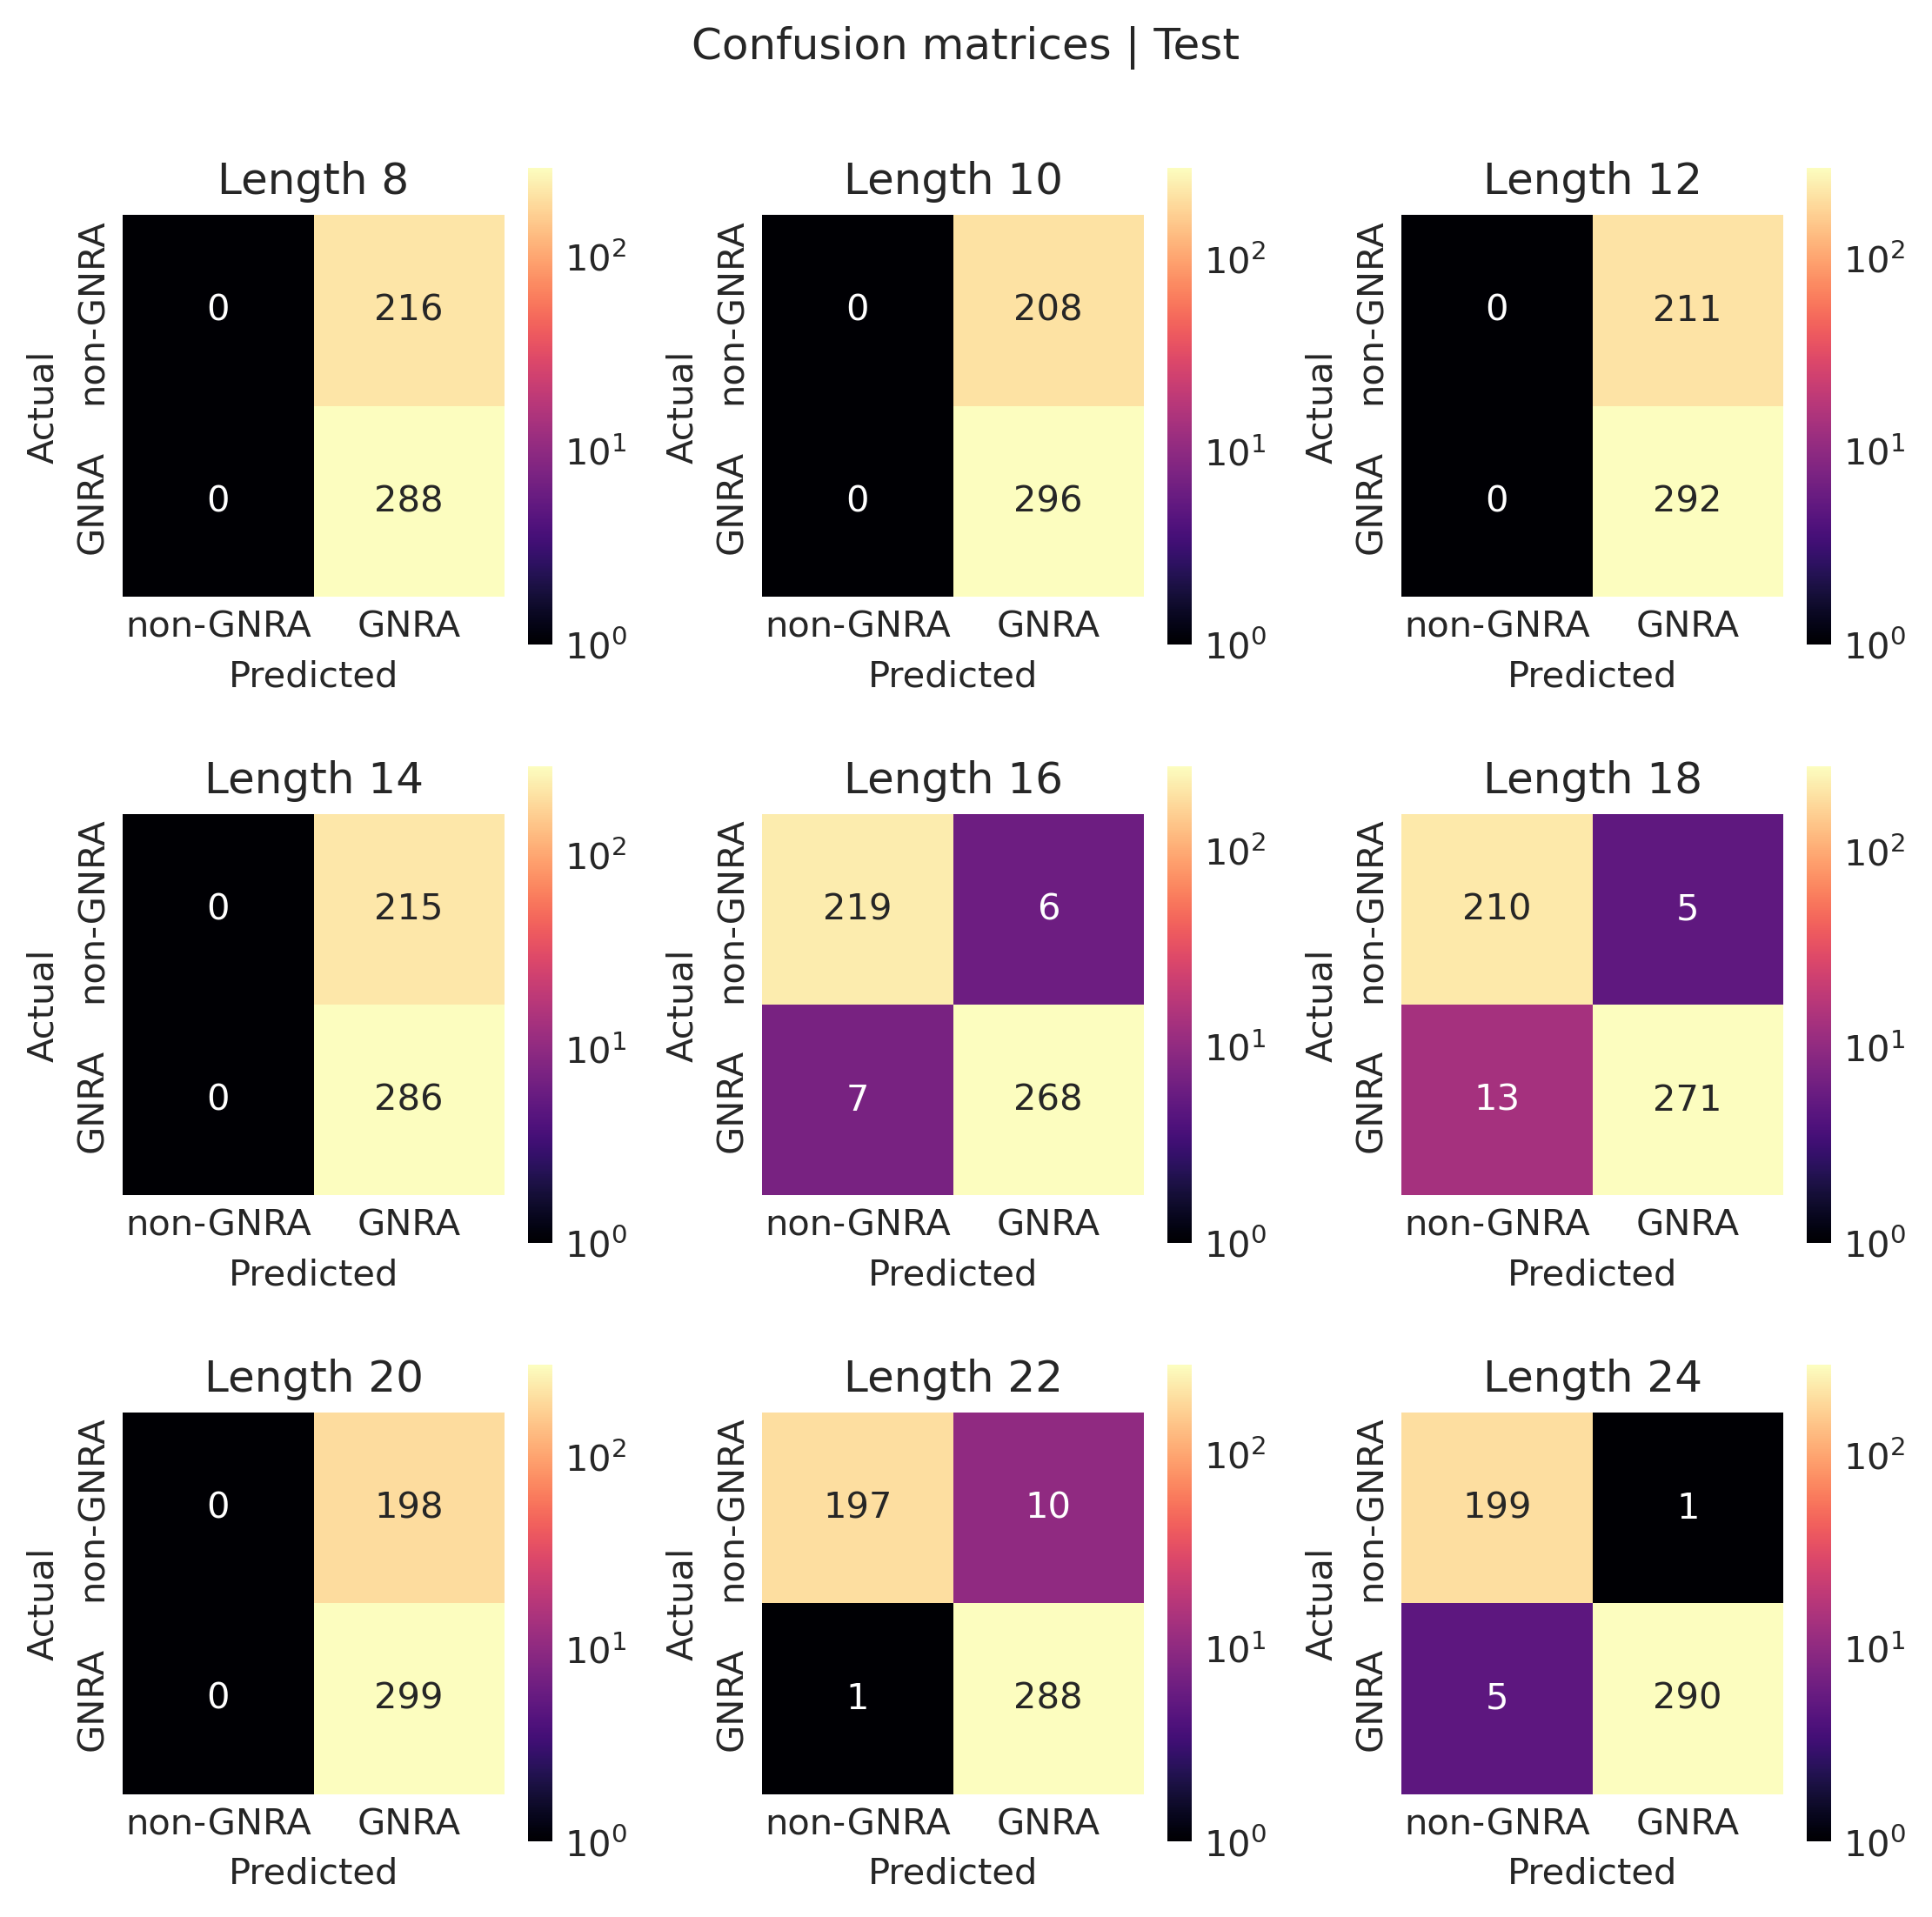

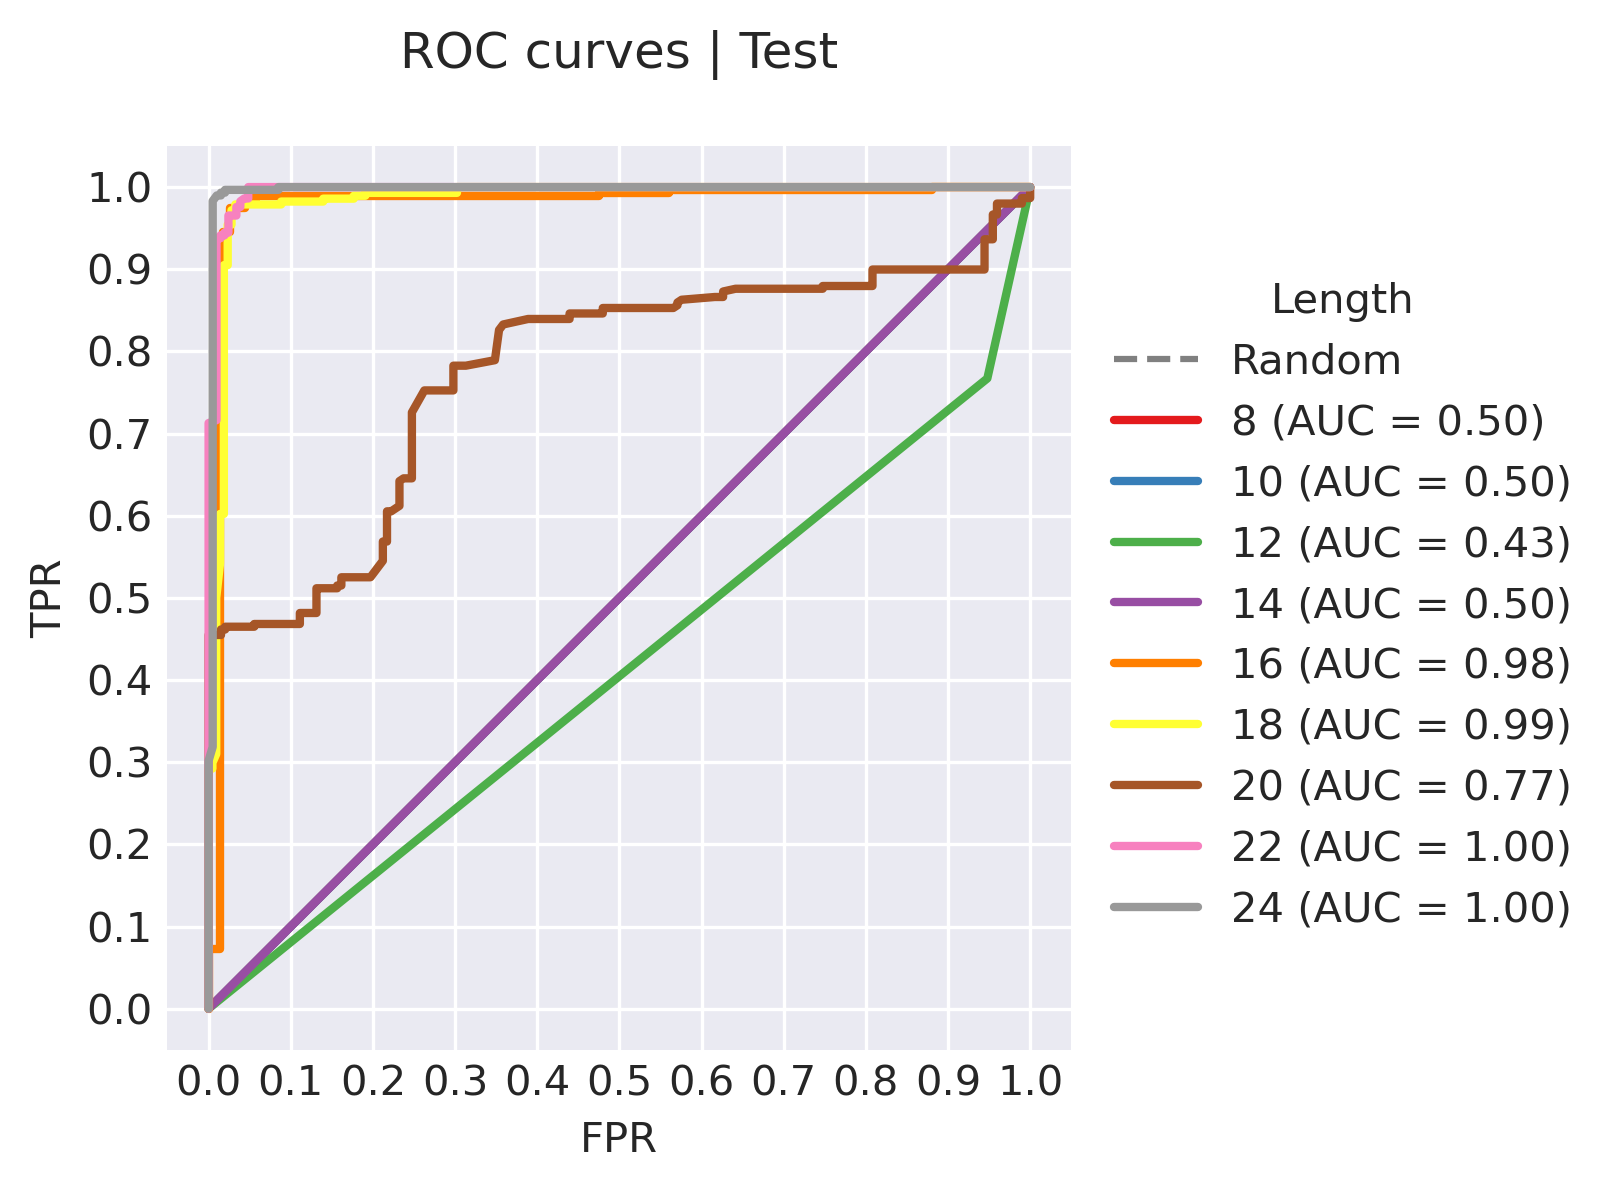

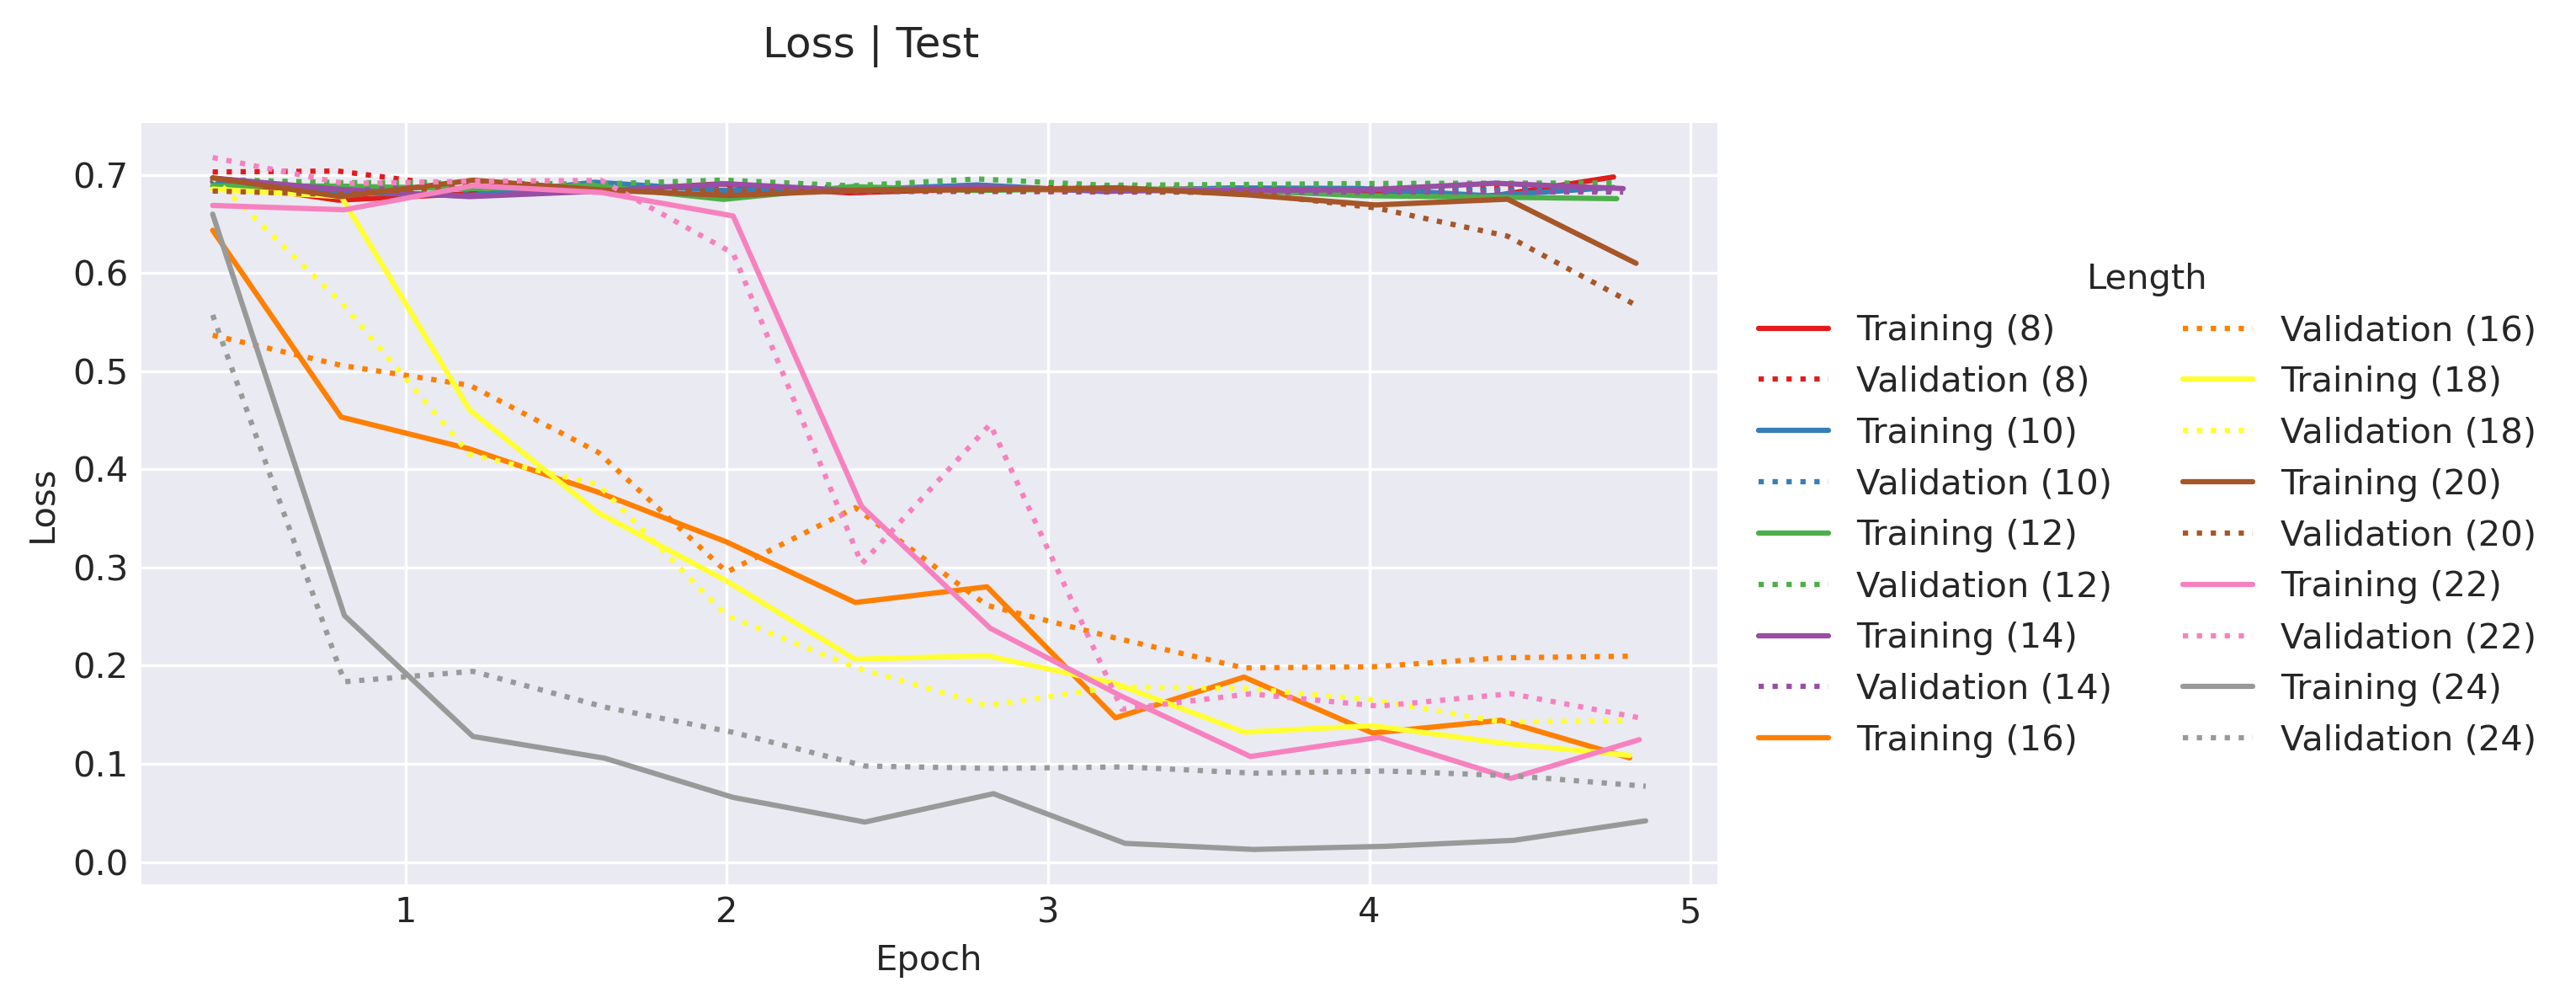

In [39]:
# Config

EVAL_RESULTS_PATH = Path("results/dnabert2_results")
TASK_INCLUDE = ["gnra", "_T"]
TASK_EXCLUDE = []
LENGTH_IDX = 1 # Where in the dataset name is the length indicated (when separated by _)
PLOT_TITLE = "Test"
FIGURES_DIR = Path("figures/homology_reduced")
MULTICLASS = False
TASK_LABELS=["non-GNRA", "GNRA"]
# TASK_INCLUDE = ["cluster", "_T"]
# MULTICLASS = True
# TASK_LABELS=range(24)


items, titles = load_eval_items(EVAL_RESULTS_PATH, TASK_INCLUDE, TASK_EXCLUDE, LENGTH_IDX)
plot_eval_items(items, titles, PLOT_TITLE, FIGURES_DIR, task_labels=TASK_LABELS, multiclass=MULTICLASS)